# Train a NCA to Generate Structures in Minecraft 

### Imports

In [3]:
from client.minecraft_pb2 import *
from client.minecraft_pb2_grpc import *
from os import listdir
from os.path import isfile, join
import numpy as np
import torch
from matplotlib.colors import rgb2hex
import matplotlib.pyplot as plt
from einops import rearrange, repeat
import numpy as np
from IPython.display import clear_output
import torch
from hydra.utils import instantiate
from hydra.experimental import initialize, initialize_config_dir, compose

from artefact_nca.trainer.voxel_ca_trainer import VoxelCATrainer
from artefact_nca.utils.minecraft import MinecraftClient, convert_to_color, Blockloader, spawn_entities
from artefact_nca.utils.minecraft.voxel_utils import replace_colors

### Minecraft Client

In [4]:
channel = grpc.insecure_channel("localhost:5001")
client = MinecraftServiceStub(channel)

#### Read in blacksmith from nbt file
- Replace nbt dir here with your own

In [5]:
def visualize_output(ct, out):
    clear_output()
    out = rearrange(out, 'b d h w c -> b w d h c')
    argmax = np.argmax(out[:, :, :, :, :ct.num_categories], -1)
    out = replace_colors(argmax, ct.dataset.target_color_dict)[0]
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.voxels(out, facecolors=out, edgecolor='k')
    
    plt.show()
    return argmax

In [6]:
base_nbt_path = "/home/shyam/Code/evocraft-cellular-automata/structs_dataset/nbts"

Block priority:  []


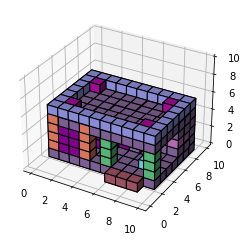

In [7]:
nbt_path = "{}/village/plain_village_blacksmith.nbt".format(base_nbt_path)
blocks, unique_vals, target, color_dict, unique_val_dict = MinecraftClient.load_entity("plain_village_blacksmith", nbt_path=nbt_path, load_coord=(50,10,10))


color_arr = convert_to_color(target, color_dict)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(color_arr, facecolors=color_arr, edgecolor='k')

plt.show()

#### Create and load in model

In [8]:
ct = VoxelCATrainer.from_config(
                    "../pretrained_models/PlainBlacksmith/plain_blacksmith.yaml",
                    config={
                        "dataset_config":{"nbt_path":nbt_path},
                        "use_cuda":True,
                        "visualize_output":True
                    }
                )

Block priority:  []


### Train

Before --- After


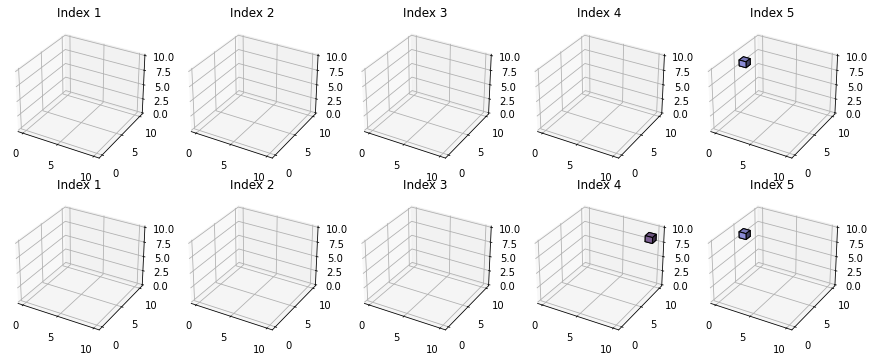

loss:0.8296537399291992--iou_loss:0.7448200583457947:   2%|▏         | 395/20000 [01:48<1:41:37,  3.22it/s]

In [ ]:
ct.train(epochs=20000, batch_size=5, checkpoint_interval=100)